# Object recognition on cifar10 dataset using CNN 

###### Using keras to import  cifar10 dataset 

In [2]:
from keras.datasets import cifar10
from matplotlib import pyplot as plt 

###### Loading data 

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

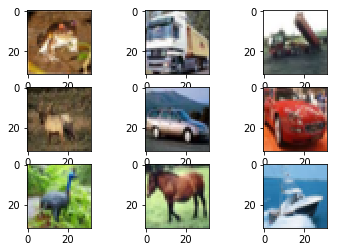

In [4]:
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
# show the plot
plt.show()

In [5]:
print  X_train.shape ,  y_train.shape
print X_test.shape , y_test.shape

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [6]:
print 'training data:', X_train.shape[0]
print 'test data:' , X_test.shape[0]

training data: 50000
test data: 10000


In [7]:
print "dimension of a single image :", X_train[1].shape

dimension of a single image : (32, 32, 3)


###### 32*32 dimensions with 3 channels ->RGB

In [8]:
print "for first channel :"
print X_train[1][:,:,0]

for first channel :
[[154 126 105 ...,  91  87  79]
 [140 145 125 ...,  96  77  71]
 [140 139 115 ...,  79  68  67]
 ..., 
 [175 156 154 ...,  42  61  93]
 [165 156 159 ..., 103 123 131]
 [163 158 163 ..., 143 143 143]]


###### importing libraries for model contruction 

In [9]:
import numpy as np
from keras.callbacks import EarlyStopping
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils

In [42]:
num_classes = 10
epochs = 200
data_augmentation = False
num_predictions = 30
batch_size = 128

###### Data Preprocessing like normalization and  one hot vectorization

In [11]:
X_train = X_train/255.0
X_test = X_test/255.0

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test , num_classes)

In [12]:
print "normalized pixel values  for first channel :\n\n" , X_train[1][: , : , 0] 

normalized pixel values  for first channel :

[[ 0.60392157  0.49411765  0.41176471 ...,  0.35686275  0.34117647
   0.30980392]
 [ 0.54901961  0.56862745  0.49019608 ...,  0.37647059  0.30196078
   0.27843137]
 [ 0.54901961  0.54509804  0.45098039 ...,  0.30980392  0.26666667
   0.2627451 ]
 ..., 
 [ 0.68627451  0.61176471  0.60392157 ...,  0.16470588  0.23921569
   0.36470588]
 [ 0.64705882  0.61176471  0.62352941 ...,  0.40392157  0.48235294
   0.51372549]
 [ 0.63921569  0.61960784  0.63921569 ...,  0.56078431  0.56078431
   0.56078431]]


In [13]:
print "new shape for y-train :",  y_train.shape

new shape for y-train : (50000, 10)


###### Creating the Model  

In [14]:
model = Sequential()

model.add(Conv2D(32,3, 3, activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


######  Summary of the Model

In [15]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 30, 30, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 28, 28, 64)    18496       convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 14, 14, 64)    0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 14, 14, 64)    0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

###### Initiating adams optimizer

In [16]:
opt  = Adam(lr=0.0001, decay=1e-6)

###### Compiling the Model

In [17]:
model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

###### Fitting the Model

In [18]:
if not data_augmentation:
    print('Not using data augmentation.')
    hist = model.fit(X_train, y_train,
              batch_size=batch_size,
              nb_epoch=epochs,
              validation_data=(X_test, y_test),
              callbacks=[EarlyStopping(min_delta=0.001, patience=3)],
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # randomly flip images

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

        # Fit the model on the batches generated by datagen.flow().
    hist_with_augmentation = model.fit_generator(datagen.flow(X_train, y_train,
                                batch_size=batch_size),
                                samples_per_epoch=x_train.shape[0] // batch_size,
                                nb_epoch=epochs, validation_data = (X_test, y_test),
                       callbacks=[EarlyStopping(min_delta=0.001, patience=3)])
        

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 242s - loss: 1.9664 - acc: 0.2645 - val_loss: 1.6975 - val_acc: 0.3784
Epoch 2/200
50000/50000 [==============================] - 249s - loss: 1.6292 - acc: 0.3954 - val_loss: 1.4795 - val_acc: 0.4609
Epoch 3/200
50000/50000 [==============================] - 261s - loss: 1.4881 - acc: 0.4575 - val_loss: 1.3786 - val_acc: 0.5060
Epoch 4/200
50000/50000 [==============================] - 259s - loss: 1.3922 - acc: 0.4978 - val_loss: 1.2908 - val_acc: 0.5400
Epoch 5/200
50000/50000 [==============================] - 261s - loss: 1.3234 - acc: 0.5234 - val_loss: 1.2281 - val_acc: 0.5654
Epoch 6/200
50000/50000 [==============================] - 264s - loss: 1.2594 - acc: 0.5501 - val_loss: 1.1690 - val_acc: 0.5842
Epoch 7/200
50000/50000 [==============================] - 264s - loss: 1.2101 - acc: 0.5675 - val_loss: 1.1388 - val_acc: 0.5973
Epoch 8/200

      The validation accuracy reaches 0.79 after 60 epochs when the early stopping terminates the process because the  validation loss has stopped decreasing (the final value is about 0.6).

###### the above model reaches an accuracy of around 79% with 60 epochs having a batch size of 128 and the optimizer being used is adam's optimizer

###### model evaluation :

In [19]:
scores = model.evaluate(X_test , y_test)
print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

10000/10000 [==============================] - 15s    
Loss: 0.663
Accuracy: 0.774


In [49]:
h_data = hist.history


In [48]:
print h_data
print h_data.keys()

{'acc': [0.26451999998092651, 0.39544000001907348, 0.45747999998092653, 0.49778, 0.52341999996185307, 0.55011999998092653, 0.56752000000000002, 0.58367999999999998, 0.60055999999999998, 0.61336000003814695, 0.62383999996185302, 0.63426000000000005, 0.64181999996185302, 0.65458000001907346, 0.66054000003814695, 0.66709999996185299, 0.67654000000000003, 0.68402000001907348, 0.68988000000000005, 0.69444000001907347, 0.70247999996185306, 0.70559999998092648, 0.70942000003814698, 0.71641999996185302, 0.72210000003814701, 0.72510000001907349, 0.73231999999999997, 0.73515999996185299, 0.74108000001907348, 0.74361999999999995, 0.74850000000000005, 0.75543999998092648, 0.75442000003814702, 0.76170000003814697, 0.76454000001907352, 0.76700000003814695, 0.77188000001907353, 0.77354000001907353, 0.77829999998092647, 0.78052000001907351, 0.780679999961853, 0.78491999999999995, 0.78751999998092648, 0.79056000001907345], 'loss': [1.9664463576889037, 1.6292040563201904, 1.4881458276748658, 1.392235374

## Visualization for loss and accuracy of the model  

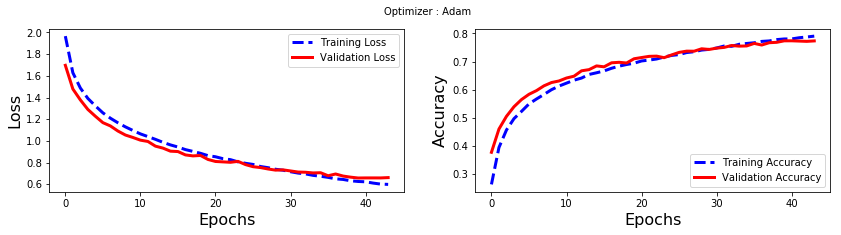

In [32]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=16)

plt.plot(hist.history['loss'], 'b--', label='Training Loss', linewidth=3)
plt.plot(hist.history['val_loss'], 'r', label='Validation Loss' ,linewidth=3)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(hist.history['acc'], 'b--', label='Training Accuracy' , linewidth=3)
plt.plot(hist.history['val_acc'], 'r', label='Validation Accuracy' , linewidth=3)
plt.legend(loc='lower right')
plt.show()

#### Prediction Analysis 

In [34]:
import os
import pickle
import numpy as np

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'final_cifar10_trained_model.h5'

######  saving model in HDF5 file for prediction purpose  

In [35]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)


Saved trained model at /home/shujareshi/study/OpenSourceProject/cifar_with_cnn/saved_models/final_cifar10_trained_model.h5 


###### loading label names  

In [36]:
label_list_path = 'datasets/cifar-10-batches-py/batches.meta'

In [37]:
keras_dir = os.path.expanduser(os.path.join('~', '.keras'))
datadir_base = os.path.expanduser(keras_dir)
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
label_list_path = os.path.join(datadir_base, label_list_path)

In [38]:
with open(label_list_path, mode='rb') as f:
    labels = pickle.load(f)

In [41]:
predict_gen = model.predict(X_test)
print predict_gen.shape

(10000, 10)


In [43]:
for predict_index, predicted_y in enumerate(predict_gen):
    actual_label = labels['label_names'][np.argmax(y_test[predict_index])]
    predicted_label = labels['label_names'][np.argmax(predicted_y)]
    print('Actual Label = %s vs. Predicted Label = %s' % (actual_label,
                                                          predicted_label))
    if predict_index == num_predictions:
        break

Actual Label = cat vs. Predicted Label = cat
Actual Label = ship vs. Predicted Label = ship
Actual Label = ship vs. Predicted Label = ship
Actual Label = airplane vs. Predicted Label = airplane
Actual Label = frog vs. Predicted Label = frog
Actual Label = frog vs. Predicted Label = frog
Actual Label = automobile vs. Predicted Label = automobile
Actual Label = frog vs. Predicted Label = frog
Actual Label = cat vs. Predicted Label = cat
Actual Label = automobile vs. Predicted Label = automobile
Actual Label = airplane vs. Predicted Label = dog
Actual Label = truck vs. Predicted Label = truck
Actual Label = dog vs. Predicted Label = cat
Actual Label = horse vs. Predicted Label = horse
Actual Label = truck vs. Predicted Label = truck
Actual Label = ship vs. Predicted Label = ship
Actual Label = dog vs. Predicted Label = dog
Actual Label = horse vs. Predicted Label = cat
Actual Label = ship vs. Predicted Label = ship
Actual Label = frog vs. Predicted Label = frog
Actual Label = horse vs. Pr

###### Testing for a single image  

In [70]:
#testing for a single image
from keras.preprocessing import image as image_utils
test_image = image_utils.load_img('bike.jpg', target_size=(32, 32))
test_image = image_utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict_on_batch(test_image)


#print(result)
predicted_label = labels['label_names'][np.argmax(result)]
print (predicted_label)


frog
